In [1]:
#Code to build the Decision tree as per the given conditions in Question 1.

import numpy as np
import pandas as pd
from collections import Counter
from math import log2

class Node:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value


def calculate_entropy(y):
    count = Counter(y)
    p = np.array(list(count.values())) / len(y)
    return -np.sum(p * np.log2(p))


def find_best_split(X, y):
    best_gain_ratio = 0
    best_feature_index = None
    best_threshold = None
    best_left_indices = None
    best_right_indices = None
    
    parent_entropy = calculate_entropy(y)
    for feature_index in range(X.shape[1]):
        for threshold in set(X[:, feature_index]):
            left_indices = np.where(X[:, feature_index] >= threshold)[0]
            right_indices = np.where(X[:, feature_index] < threshold)[0]
            
            if len(left_indices) == 0 or len(right_indices) == 0:
                continue
                
            left_entropy = calculate_entropy(y[left_indices])
            right_entropy = calculate_entropy(y[right_indices])
            child_entropy = (len(left_indices) / len(y)) * left_entropy + (len(right_indices) / len(y)) * right_entropy
            
            gain = parent_entropy - child_entropy
            split_info = -((len(left_indices) / len(y)) * log2(len(left_indices) / len(y))
                           + (len(right_indices) / len(y)) * log2(len(right_indices) / len(y)))
            gain_ratio = gain / split_info
            
            if gain_ratio > best_gain_ratio:
                best_gain_ratio = gain_ratio
                best_feature_index = feature_index
                best_threshold = threshold
                best_left_indices = left_indices
                best_right_indices = right_indices
                
    return best_feature_index, best_threshold, best_left_indices, best_right_indices


def build_tree(X, y, depth=1, max_depth=np.inf):
#     print(f"Depth: {depth}, Unique Labels: {set(y)}")  # Printing Depth and Unique Labels at this node // for debugging
    if len(set(y)) == 1 or len(y) == 0 or depth > max_depth:
        return Node(value=Counter(y).most_common(1)[0][0] if len(y) > 0 else 1)
    
    feature_index, threshold, left_indices, right_indices = find_best_split(X, y)
    
#     print(f"Chosen Split: Feature {feature_index}, Threshold {threshold}")  # Printing the chosen split // for debugging
    if feature_index is None:
        return Node(value=Counter(y).most_common(1)[0][0])
    
    left = build_tree(X[left_indices], y[left_indices], depth + 1, max_depth)
    right = build_tree(X[right_indices], y[right_indices], depth + 1, max_depth)
    
    return Node(feature_index, threshold, left, right)


def predict(tree, x):
    if tree.value is not None:
        return tree.value
    if x[tree.feature_index] >= tree.threshold:
        return predict(tree.left, x)
    return predict(tree.right, x)


In [2]:
# Load Data
data = pd.read_csv('Dbig.txt', sep=' ', header=None)
data.columns = ['X1', 'X2', 'Y']

X = data[['X1', 'X2']].values
y = data['Y'].values

# Build Tree
tree = build_tree(X, y)

# Example Prediction
sample_index = 0
print(f"Predicted Label: {predict(tree, X[sample_index])}, True Label: {y[sample_index]}")

Predicted Label: 1, True Label: 1


In [3]:
#Draw tree pdf
import graphviz

def visualize_tree(node, dot=None):
    if dot is None:
        dot = graphviz.Digraph(comment='The Decision Tree')
    if node.value is not None:  # Leaf node
        dot.node(f'{id(node)}', f'{node.value}', shape='ellipse', color='black')
    else:
        dot.node(f'{id(node)}', f'X {node.feature_index+1} >= {node.threshold}?', shape='box', color='black')
        dot, left_child_id = visualize_tree(node.left, dot)
        dot, right_child_id = visualize_tree(node.right, dot)
        dot.edge(f'{id(node)}', f'{left_child_id}', label='True', color='blue')
        dot.edge(f'{id(node)}', f'{right_child_id}', label='False', color='red')
    return dot, id(node)

# Use the function to visualize the tree.
dot, _ = visualize_tree(tree)
dot.render('decision_tree', view=True)  # This will create and open a decision_tree.pdf file with the visualized tree

'decision_tree.pdf'

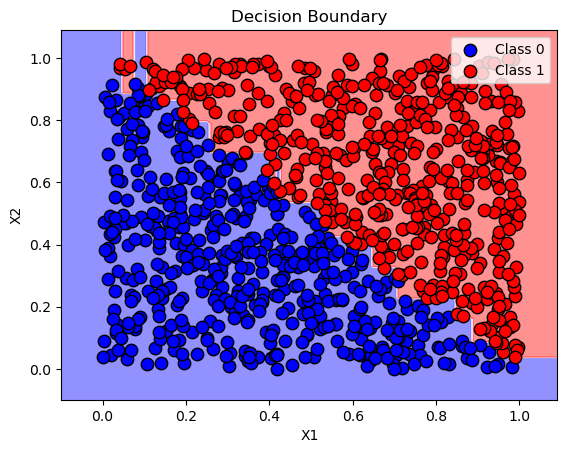

In [4]:
# Question 2 -> 6 -> 2
# Visualize Decision boundary of the trees

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


def plot_decision_boundary(X, y, tree, title):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    step_size = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step_size), np.arange(y_min, y_max, step_size))
    Z = np.array([predict(tree, x) for x in np.c_[xx.ravel(), yy.ravel()]]) ## For plotting when using my tree
#     Z = tree.predict(np.c_[xx.ravel(), yy.ravel()]) ## For plotting when using sklearn
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.5, cmap='bwr')  # Change 'viridis' to any suitable colormap
    
#     Separate scatter plots for Class 0 and Class 1 with labels
    plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='blue', edgecolors='k', marker='o', s=80, linewidth=1, label='Class 0')
    plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='red', edgecolors='k', marker='o', s=80, linewidth=1, label='Class 1')
    
    plt.title(title)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.legend(loc='upper right')
#     red_patch = mpatches.Patch(color='blue', label='Class 0')
#     blue_patch = mpatches.Patch(color='red', label='Class 1')
#     plt.legend(handles=[red_patch, blue_patch])
    plt.show()

# Plot Decision Boundaries
plot_decision_boundary(X, y, tree, 'Decision Boundary')

In [5]:
# count nodes in tree:

def count_nodes(node):
    if node is None:  # base case: if the node is None, return 0
        return 0
    
    if node.value is not None:  # base case: if it's a leaf node, return 1
        return 1
    
    # recursive case: if it's a non-leaf node, 
    # return 1 (for the current node) + the number of nodes in the left subtree + the number of nodes in the right subtree
    return 1 + count_nodes(node.left) + count_nodes(node.right)

# Now you can count the nodes in your decision tree
# tree is the root of your decision tree
number_of_nodes = count_nodes(tree)
print(f"The number of nodes in the decision tree is {number_of_nodes}")

The number of nodes in the decision tree is 61


In [6]:
#for sklearn 
# To run this code
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

def visualize_tree1(clf, feature_names):
    dot_data = export_graphviz(
        clf,
        out_file=None,
        feature_names=feature_names,
        class_names=[str(i) for i in clf.classes_],
        filled=True,
        rounded=True,
        special_characters=True
    )
    return graphviz.Source(dot_data)

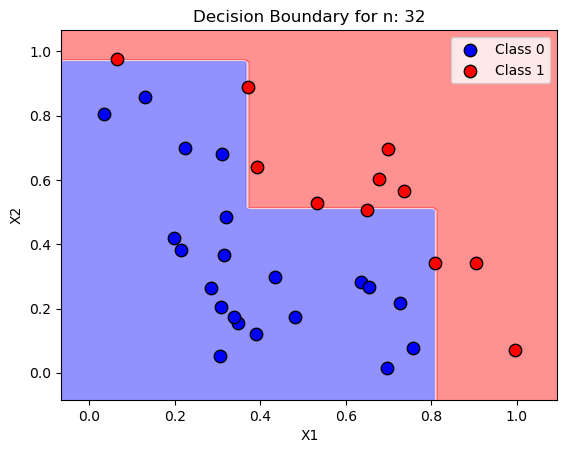

C:\Users\Patron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Patron\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


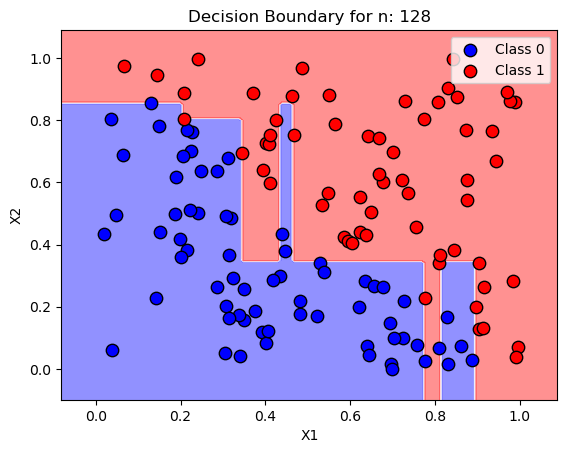

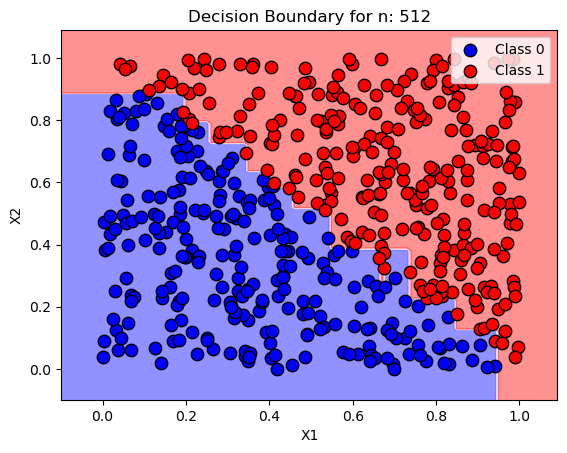

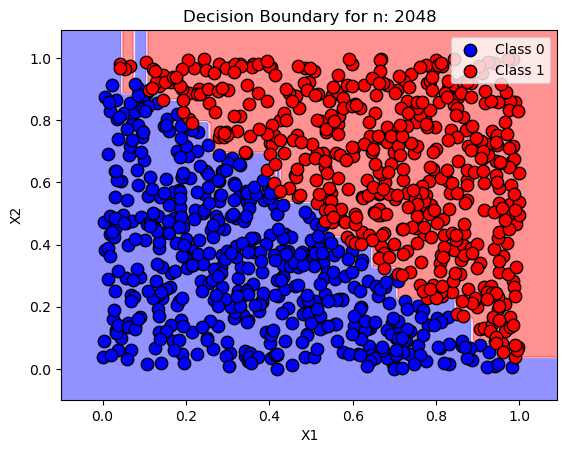

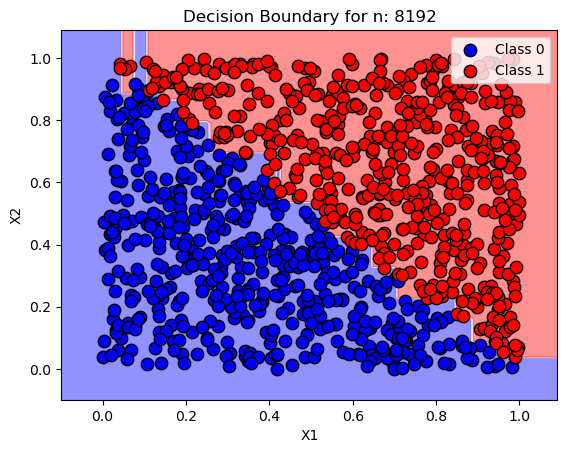

      n  No. of Nodes  err_n
0    32             9    NaN
1   128            21    NaN
2   512            41    NaN
3  2048            61    NaN
4  8192            61    NaN


In [7]:
# Split the data:
# Generate a random permutation and split at 8192
# sklearn approach for Q3 (You need to uncomment and comment out the mentioned line in the code to run specific sections)
# Currently sklearn code is commented out.
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

np.random.seed(10)  # For reproducibility
permuted_indices = np.random.permutation(len(data))

train_indices = permuted_indices[:8192]
test_indices = permuted_indices[8192:]

train_data = data.iloc[train_indices]
test_data = data.iloc[test_indices]

# Extracting X and y from test_data for later error calculation
X_test = test_data.iloc[:, :-1].values
y_test = test_data.iloc[:, -1].values


# Specifying the sizes of the training subsets
subset_sizes = [32, 128, 512, 2048, 8192]

results = []

for size in subset_sizes:
    subset_data = train_data.iloc[:size]
    X_train = subset_data.iloc[:, :-1].values
    y_train = subset_data.iloc[:, -1].values
    
    #''' Uncomment for Q2.7

    # Build the tree for each subset           // Comment out for Q3
    tree = build_tree(X_train, y_train)     # // Needed only for Q 2.7 

    # Number of nodes in the tree
    num_nodes = count_nodes(tree)
    
    # Visualize tree
    #   dot, _ = visualize_tree(tree)
    #   dot.render(str(size), view=True)  # This will create and open a [size].pdf file with the visualized tree
    plot_decision_boundary(X_train, y_train, tree, 'Decision Boundary for n: ' + str(size))
    
    # Calculate the test set error
    predictions = np.array([predict(tree, x) for x in X_test])
    err = np.mean(predictions != y_test)
    
    results.append({'n': size, 'No. of Nodes': num_nodes, 'err_n': err})
    #'''

#     # For Quesion 3 specifically... Uncomment this comment top code and uncomment in plot_decision_boundary() if you want boundary
#     # Build using sklearn for Q3
#     clf = DecisionTreeClassifier(random_state = 10)
#     clf.fit(X_train, y_train)
    
#     y_pred = clf.predict(X_test)
#     error = 1 - accuracy_score(y_test, y_pred)
    
#     # Visualize tree
#     dot = visualize_tree1(clf, feature_names=['X1', 'X2'])
#     dot.render(str(size), view=True)
    
#     plot_decision_boundary(X_train, y_train, clf, 'Decision Boundary for n: ' + str(size))
    
#     results.append({'n': size, 'No. of Nodes': clf.tree_.node_count, 'err_n': error})
    
    
    
# Convert results to DataFrame for better visualization and further analysis
results_df = pd.DataFrame(results)
print(results_df)

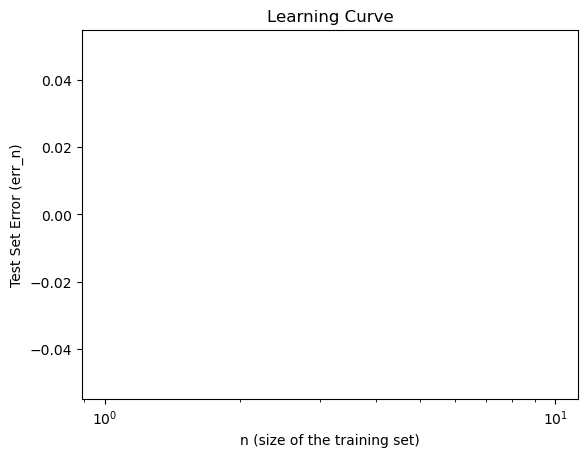

In [8]:
#Plotting the learning curve:

import matplotlib.pyplot as plt

plt.plot(results_df['n'], results_df['err_n'], marker='o')
plt.xscale('log')
plt.xlabel('n (size of the training set)')
plt.ylabel('Test Set Error (err_n)')
plt.title('Learning Curve')
plt.show()

In [9]:
# Load Data & check accuracy
# For Debugging purposes to check the accuracy of the data.
data_d2 = pd.read_csv('Dbig.txt', sep=' ', header=None)
data_d2.columns = ['X1', 'X2', 'Y']
X_d2 = data_d2[['X1', 'X2']].values
y_d2 = data_d2['Y'].values

# Make Predictions on D2 data
predictions = [predict(tree, x) for x in X_d2]

# Calculate Accuracy
accuracy = np.sum(predictions == y_d2) / len(y_d2)
print(f'Model Accuracy: {accuracy * 100:.2f}%')

Model Accuracy on D3leaves.txt: 42.73%


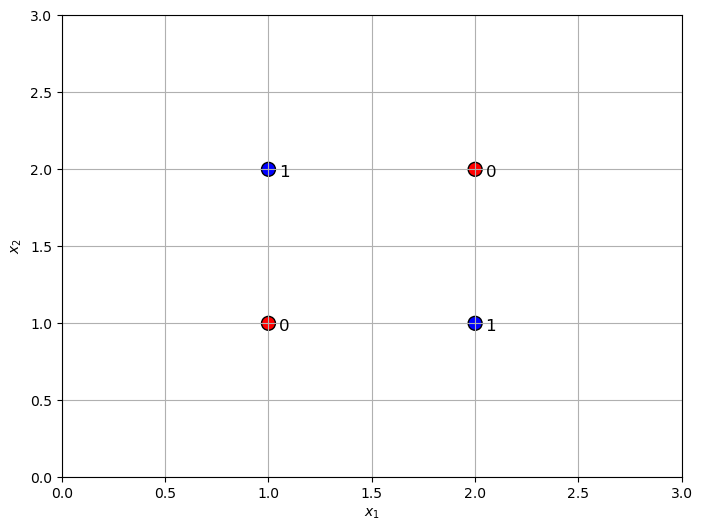

In [10]:
# Question 2.2 (1) Plot data for hand crafted data points.

import matplotlib.pyplot as plt

# Data points
x1 = [1.0, 1.0, 2.0, 2.0]
x2 = [1.0, 2.0, 1.0, 2.0]
y = [0, 1, 1, 0]

# Color map: class 0 = red, class 1 = blue
colors = ['red' if label == 0 else 'blue' for label in y]

plt.figure(figsize=(8, 6))
plt.scatter(x1, x2, c=colors, s=100, edgecolors='k')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
# plt.title('Data Points Visualization')
plt.grid(True)
plt.xlim(0, 3)
plt.ylim(0, 3)
for i, txt in enumerate(y):
    plt.annotate(txt, (x1[i]+0.05, x2[i]-0.05), fontsize=12)
plt.show()


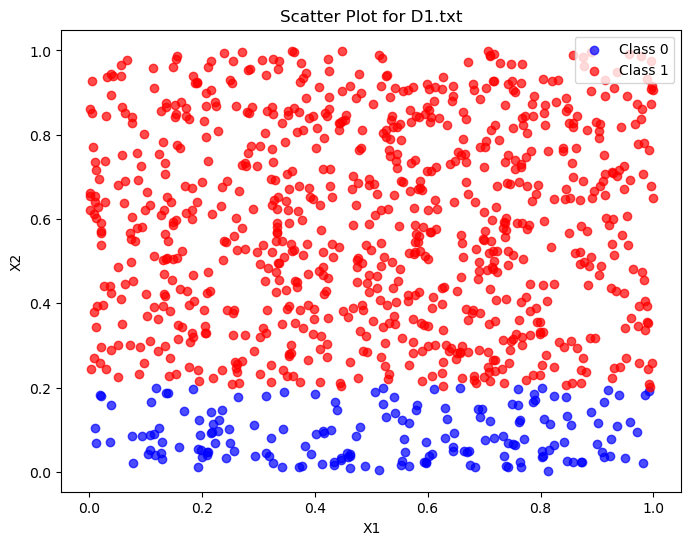

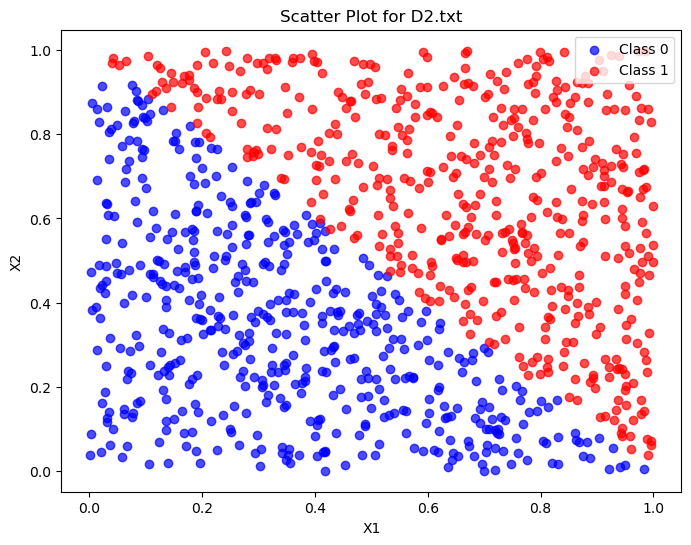

In [11]:
#Question 2-> 6 -> 1
# Create scatter plot of the data in D1.txt and D2.txt

import matplotlib.pyplot as plt
import pandas as pd

columns = ['X1', 'X2', 'Y']

d1 = pd.read_csv('D1.txt', sep='\s+', names=columns)
d2 = pd.read_csv('D2.txt', sep='\s+', names=columns)

def scatter_plot(df, title):
    plt.figure(figsize=(8,6))
    plt.scatter(df[df['Y'] == 0]['X1'], df[df['Y'] == 0]['X2'], label='Class 0', color='b', alpha=0.7)
    plt.scatter(df[df['Y'] == 1]['X1'], df[df['Y'] == 1]['X2'], label='Class 1', color='r', alpha=0.7)
    plt.title(title)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.legend(loc='upper right')
    plt.show()

scatter_plot(d1, 'Scatter Plot for D1.txt')
scatter_plot(d2, 'Scatter Plot for D2.txt')


In [12]:
#Question 4 Lagrange Interpolation

import numpy as np
from scipy.interpolate import lagrange
import matplotlib.pyplot as plt

# Training Data Generation
n = 100
a = 0
b = 10
np.random.seed(42)  # for reproducibility
x_train = np.random.uniform(a, b, n)
y_train = np.sin(x_train)

# Construct Lagrange Polynomial
f = lagrange(x_train, y_train)

# Test Data Generation
x_test = np.random.uniform(a, b, n)
y_test = np.sin(x_test)

# Compute Log Mean Squared Error
def log_mse(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    return np.log(mse) if mse > 0 else 0

train_log_error = log_mse(y_train, f(x_train))
test_log_error = log_mse(y_test, f(x_test))

print("Train Log Mean Squared Error: ", train_log_error)
print("Test Log Mean Squared Error: ", test_log_error)

Train Log Mean Squared Error:  320.42889765265113
Test Log Mean Squared Error:  320.20778524030663


Epsilon: 0.0
Train Log Mean Squared Error:  320.42889765265113
Test Log Mean Squared Error:  320.20778524030663
-----
Epsilon: 2.7777777777777777
Train Log Mean Squared Error:  343.7962803417989
Test Log Mean Squared Error:  311.42371688420377
-----
Epsilon: 5.555555555555555
Train Log Mean Squared Error:  303.23457778105126
Test Log Mean Squared Error:  192.08168901474713
-----
Epsilon: 8.333333333333332
Train Log Mean Squared Error:  311.8133202424328
Test Log Mean Squared Error:  141.47638341799006
-----
Epsilon: 11.11111111111111
Train Log Mean Squared Error:  303.13290636662697
Test Log Mean Squared Error:  110.13247740489462
-----
Epsilon: 13.88888888888889
Train Log Mean Squared Error:  318.1240146722174
Test Log Mean Squared Error:  93.51515203045915
-----
Epsilon: 16.666666666666664
Train Log Mean Squared Error:  285.1053483200656
Test Log Mean Squared Error:  51.476550099975626
-----
Epsilon: 19.444444444444443
Train Log Mean Squared Error:  301.90615314463446
Test Log Mean S

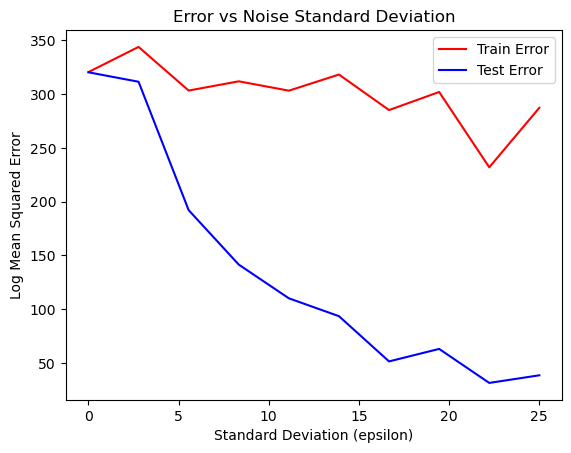

In [13]:
# Vary epsilon and store errors:

epsilons = np.linspace(0, 25, 10)  # Example range
train_errors = []
test_errors = []

for epsilon in epsilons:
    x_train_noisy = x_train + np.random.normal(0, epsilon, n)
    y_train_noisy = np.sin(x_train_noisy)
    
    # Construct Lagrange Polynomial with Noisy Data
    f_noisy = lagrange(x_train_noisy, y_train_noisy)
    
    # Compute Errors and store them in the lists
    train_errors.append(log_mse(y_train_noisy, f_noisy(x_train_noisy)))
    test_errors.append(log_mse(y_test, f_noisy(x_test)))
    
    train_log_error = log_mse(y_train_noisy, f_noisy(x_train_noisy))
    test_log_error = log_mse(y_test, f_noisy(x_test))
    
    print(f"Epsilon: {epsilon}")
    print("Train Log Mean Squared Error: ", train_log_error)
    print("Test Log Mean Squared Error: ", test_log_error)
    print("-----")

# Plotting
plt.plot(epsilons, train_errors, 'r', label='Train Error')
plt.plot(epsilons, test_errors, 'b', label='Test Error')
plt.xlabel('Standard Deviation (epsilon)')
plt.ylabel('Log Mean Squared Error')
plt.title('Error vs Noise Standard Deviation')
plt.legend()
plt.show()


In [14]:
# Visulaizing using if () -> then -> else. 
# No longer using this instead implemented graphviz to draw and delete the tree graphically

# def visualize_tree(node, depth=5, prefix="Root: "):
#     if node is not None:
#         print("  " * depth + prefix + ("" if node.value is not None else f"Feature {node.feature_index} >= {node.threshold}?"))
#         if node.value is not None:
#             print("  " * (depth + 1) + f"Class: {node.value}")
#         else:
#             visualize_tree(node.left, depth + 1, "Then: ")
#             visualize_tree(node.right, depth + 1, "Else: ")

# visualize_tree(tree)
